In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label
from skimage.feature import graycomatrix, graycoprops
import mahotas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter


In [25]:
folder_path = r"C:\Users\hafiz\OneDrive\Gambar\Screenshots\citra digital\darah"
class_folders = os.listdir(folder_path)

image_counts = {}
image_shapes = {}

for cls in class_folders:
    img_folder_path = os.path.join(folder_path, cls)
    img_files = [f for f in os.listdir(img_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    image_counts[cls] = len(img_files)

    if img_files:
        img_path = os.path.join(img_folder_path, img_files[0])
        with Image.open(img_path) as img:
            image_shapes[cls] = img.size


EDA

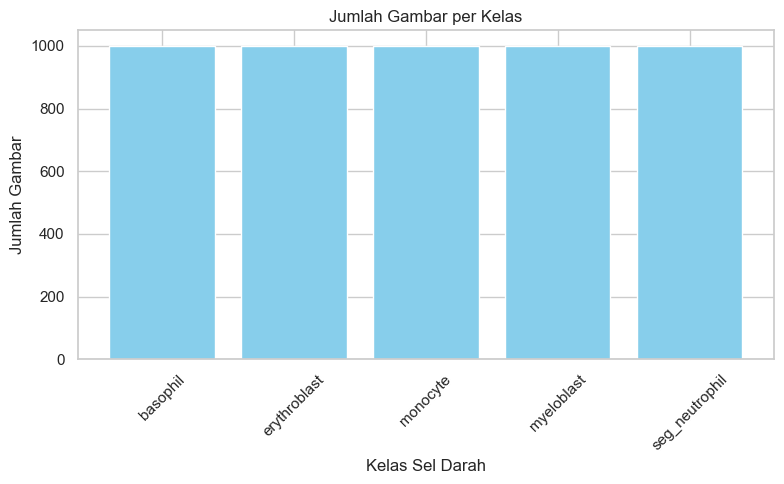

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title("Jumlah Gambar per Kelas")
plt.xlabel("Kelas Sel Darah")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
print("Ukuran Gambar Pertama per Kelas:")
for cls, shape in image_shapes.items():
    print(f"- {cls}: {shape}")


Ukuran Gambar Pertama per Kelas:
- basophil: (360, 363)
- erythroblast: (360, 363)
- monocyte: (360, 363)
- myeloblast: (400, 400)
- seg_neutrophil: (400, 400)


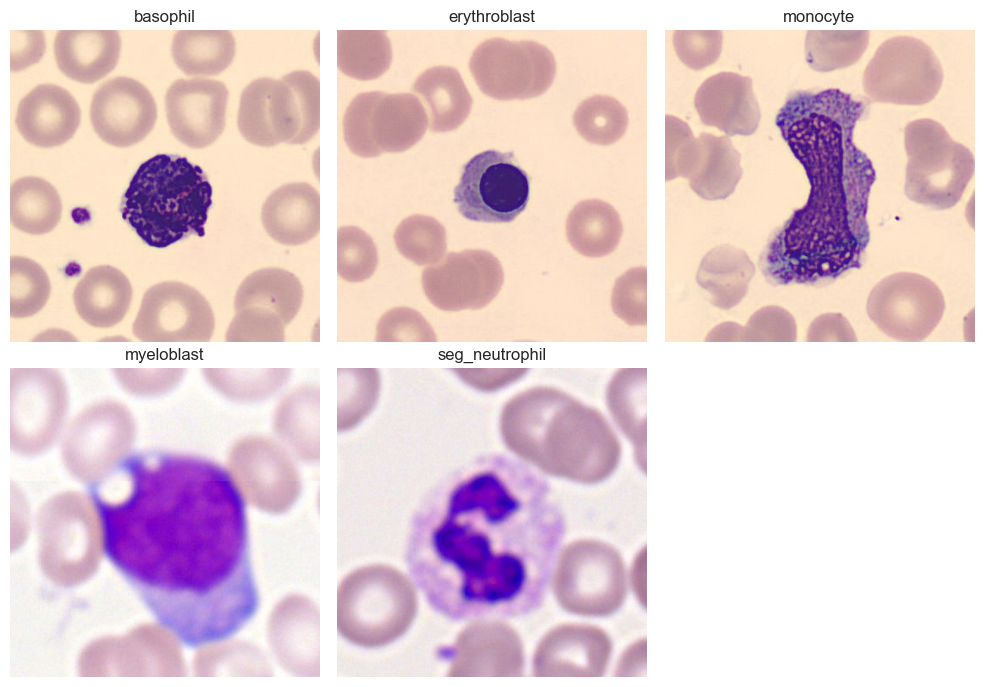

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  
axes = axes.ravel()
for i, cls in enumerate(class_folders[:5]):
    img_folder_path = os.path.join(folder_path, cls)
    image_name = os.listdir(img_folder_path)[0]
    img_path = os.path.join(img_folder_path, image_name)
    image = mpimg.imread(img_path)
    axes[i].imshow(image)
    axes[i].set_title(cls)
    axes[i].axis('off')  


for j in range(i + 1, 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


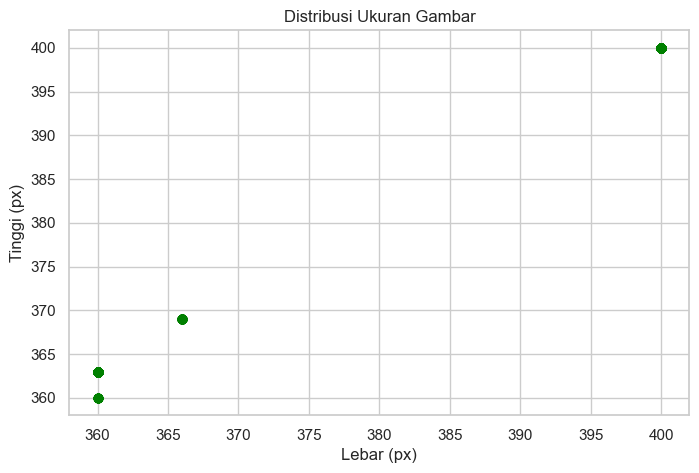

In [ ]:
image_sizes = []
avg_colors = {}  
gray_histograms = {}

for cls in class_folders:
    cls_folder = os.path.join(folder_path, cls)
    img_files = [f for f in os.listdir(cls_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    rgb_means = []

    for img_name in img_files:
        img_path = os.path.join(cls_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w, _ = img.shape
        image_sizes.append((w, h))

        rgb_mean = img.mean(axis=(0, 1)) 
        rgb_means.append(rgb_mean[::-1]) 

    if rgb_means:
        avg_colors[cls] = np.mean(rgb_means, axis=0)
        
    
    if img_files:
        img_path = os.path.join(cls_folder, img_files[0])
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
        gray_histograms[cls] = hist

widths, heights = zip(*image_sizes)
plt.figure(figsize=(8, 5))
plt.scatter(widths, heights, alpha=0.5, color='green')
plt.title("Distribusi Ukuran Gambar")
plt.xlabel("Lebar (px)")
plt.ylabel("Tinggi (px)")
plt.grid(True)
plt.show()


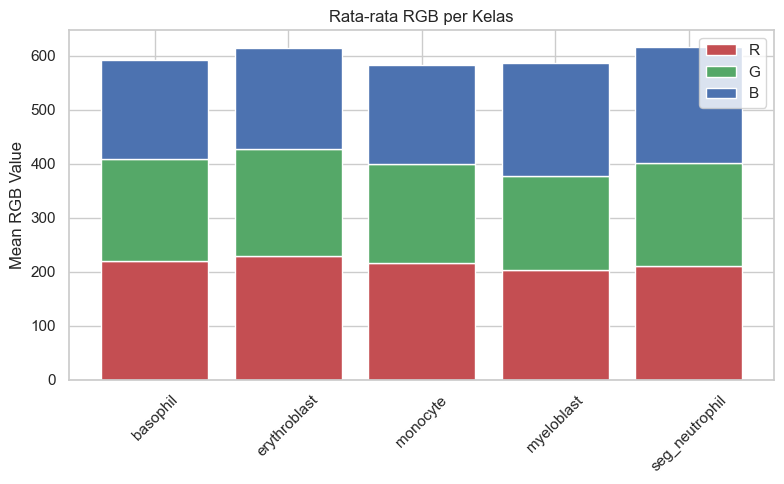

In [30]:
plt.figure(figsize=(8, 5))
for cls, color in avg_colors.items():
    plt.bar(cls, color[0], color='r', label='R' if cls == list(avg_colors)[0] else "")
    plt.bar(cls, color[1], bottom=color[0], color='g', label='G' if cls == list(avg_colors)[0] else "")
    plt.bar(cls, color[2], bottom=color[0]+color[1], color='b', label='B' if cls == list(avg_colors)[0] else "")
plt.ylabel("Mean RGB Value")
plt.title("Rata-rata RGB per Kelas")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


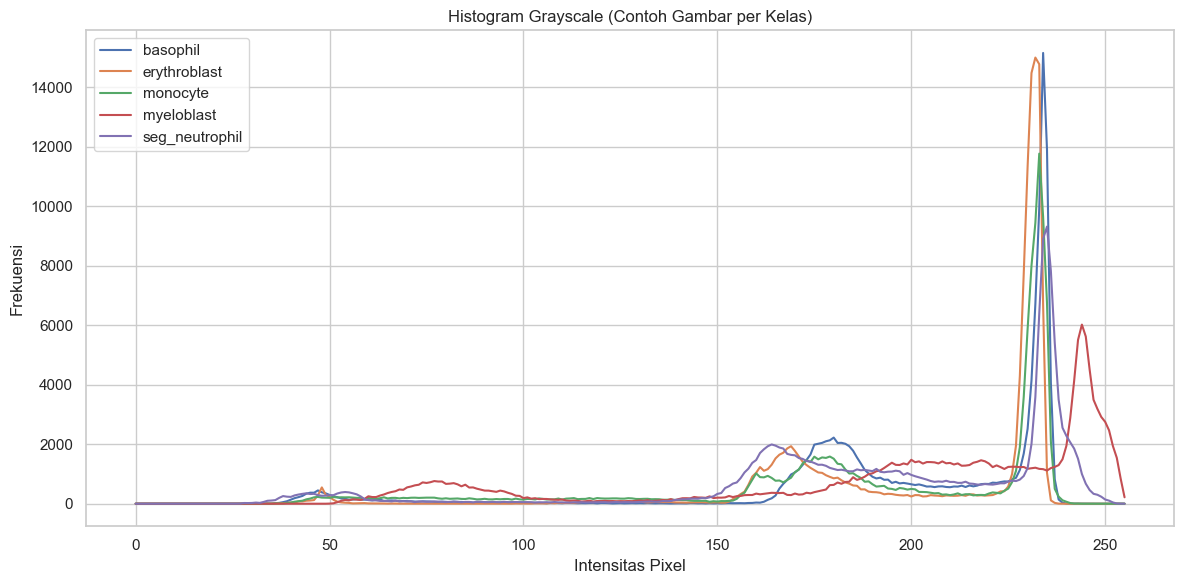

In [31]:
plt.figure(figsize=(12, 6))
for cls, hist in gray_histograms.items():
    plt.plot(hist, label=cls)
plt.title("Histogram Grayscale (Contoh Gambar per Kelas)")
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.legend()
plt.tight_layout()
plt.show()


Prepros

In [32]:
categories = ["basophil", "erythroblast", "monocyte", "myeloblast", "seg_neutrophil"]
img_size = 224
preprocessed_images = []
labels = []
example_images = {}

for category in categories:
    path = os.path.join(folder_path, category)
    class_num = categories.index(category)
    
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (img_size, img_size))
            gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            preprocessed_images.append(blurred)
            labels.append(class_num)

            if category not in example_images:
                example_images[category] = (img_resized, gray, blurred)
            break  
        except Exception as e:
            print(f"Gagal proses gambar: {img_name}")


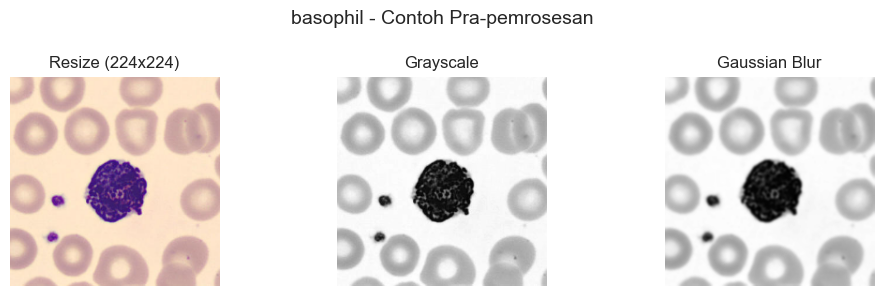

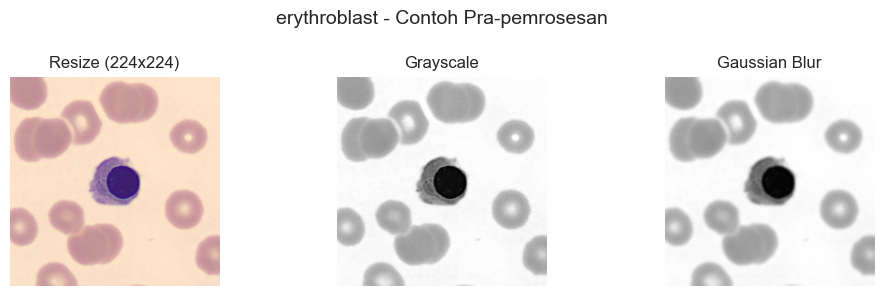

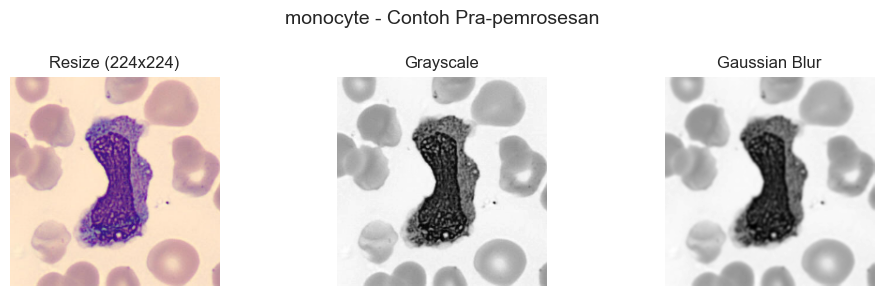

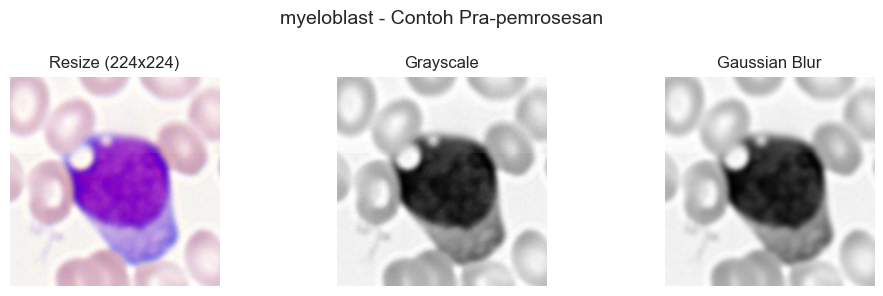

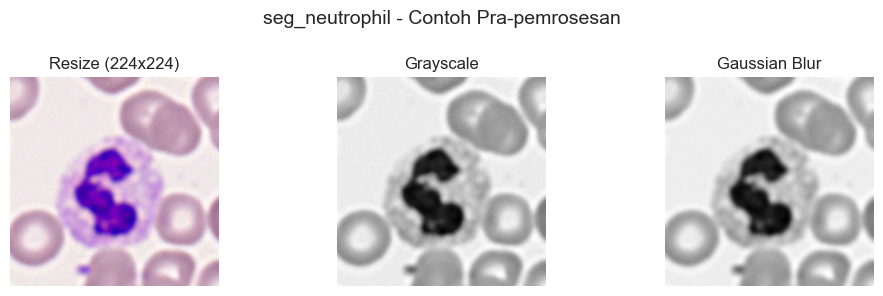

In [33]:
for category in example_images:
    resized, gray, blurred = example_images[category]
    
    plt.figure(figsize=(10, 3))
    plt.suptitle(f"{category} - Contoh Pra-pemrosesan", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(resized[..., ::-1])  
    plt.title("Resize (224x224)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title("Gaussian Blur")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


OTSU

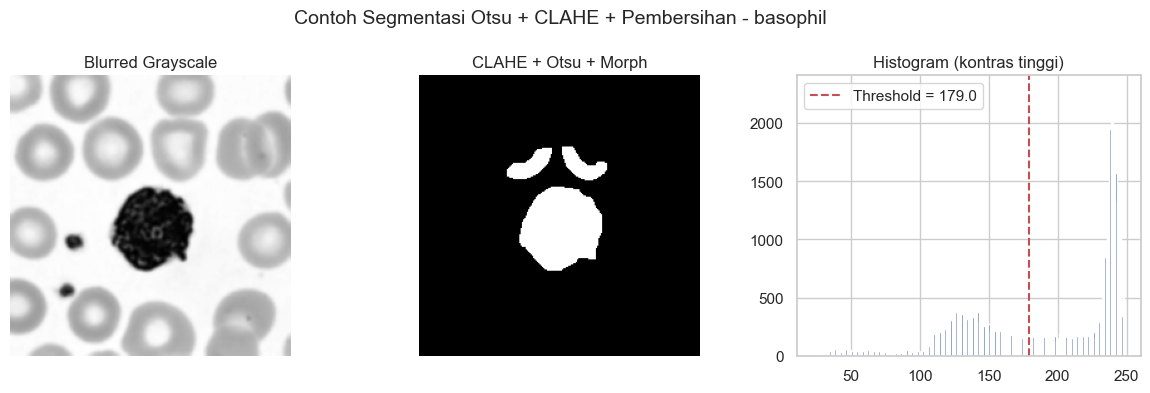

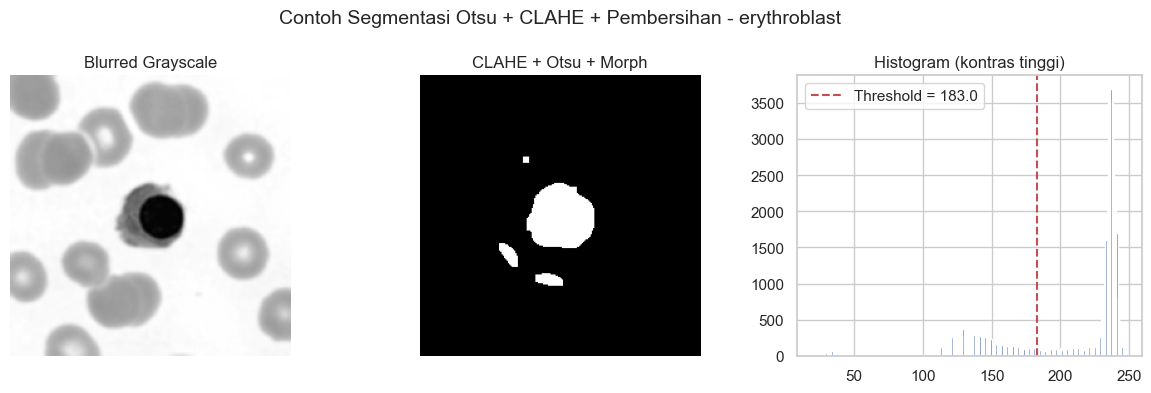

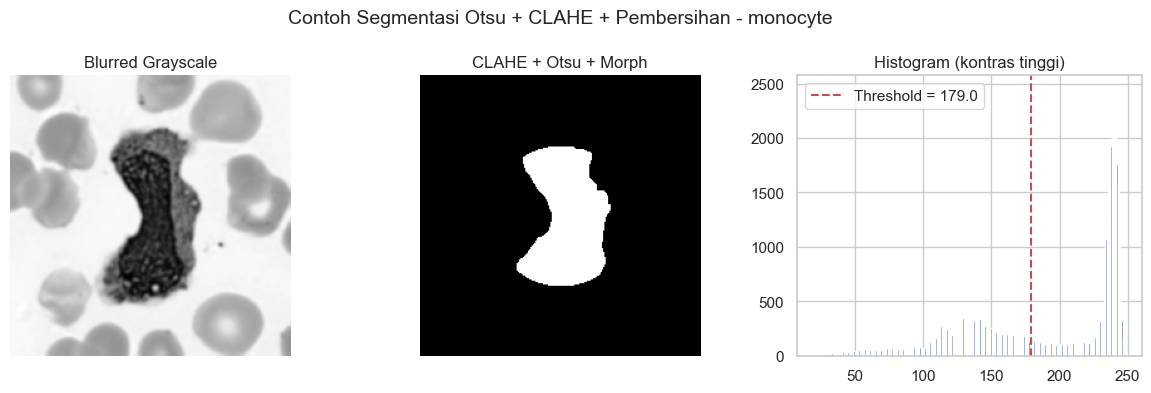

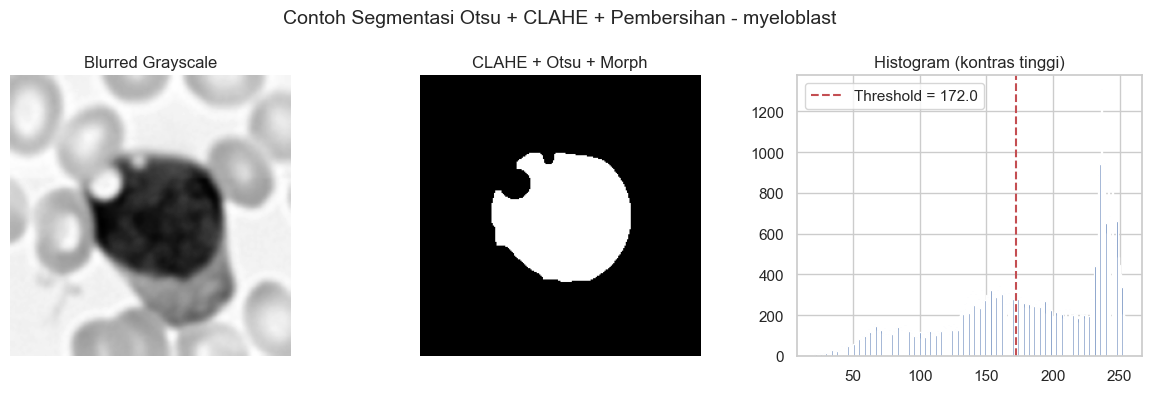

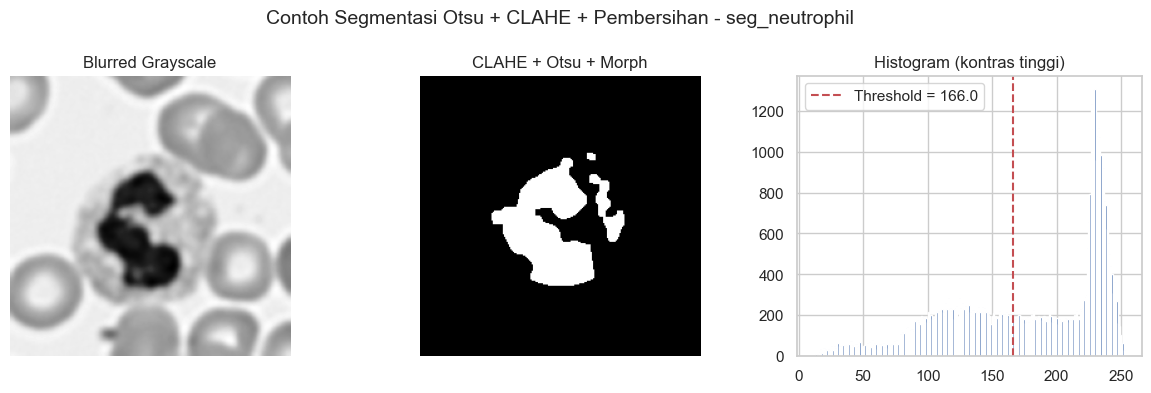

In [34]:
otsu_segmented = []


kernel = np.ones((5, 5), np.uint8)


for img in preprocessed_images:
    _, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    

    cleaned = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    otsu_segmented.append(cleaned)


for category, (_, _, blurred) in example_images.items():

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_img = clahe.apply(blurred)


    thresh_val, otsu = cv2.threshold(
        contrast_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

 
    h, w = blurred.shape
    mask = np.zeros_like(blurred)
    cv2.circle(mask, (w//2, h//2), radius=min(w, h)//4, color=255, thickness=-1)

    
    masked_otsu = cv2.bitwise_and(otsu, otsu, mask=mask)

    
    cleaned = cv2.morphologyEx(masked_otsu, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Contoh Segmentasi Otsu + CLAHE + Pembersihan - {category}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred Grayscale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cleaned, cmap='gray')
    plt.title("CLAHE + Otsu + Morph")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.hist(contrast_img.ravel(), bins=256)
    plt.axvline(thresh_val, color='r', linestyle='--', label=f"Threshold = {thresh_val:.1f}")
    plt.title("Histogram (kontras tinggi)")
    plt.legend()

    plt.tight_layout()
    plt.show()


Adaptive

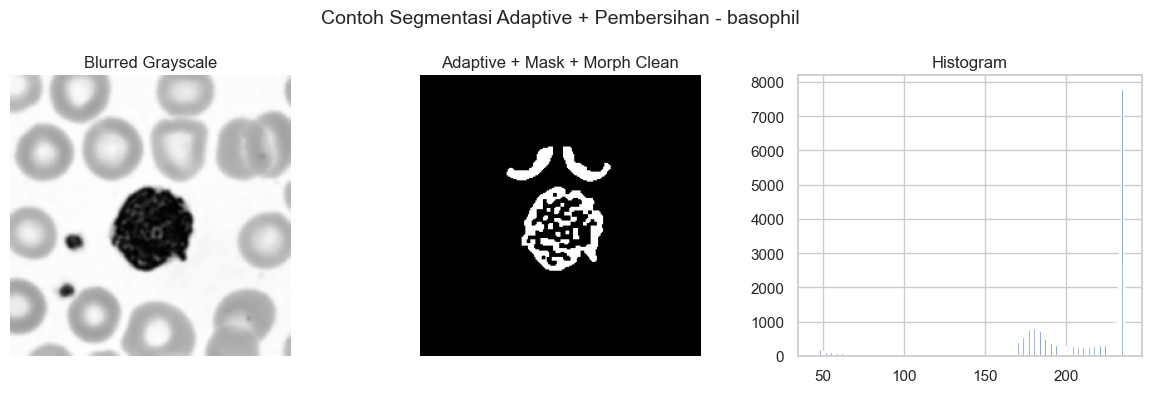

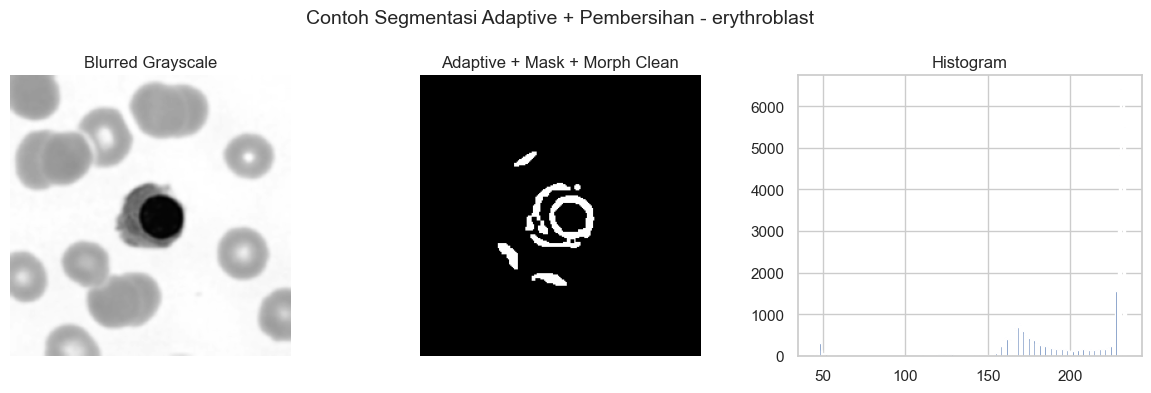

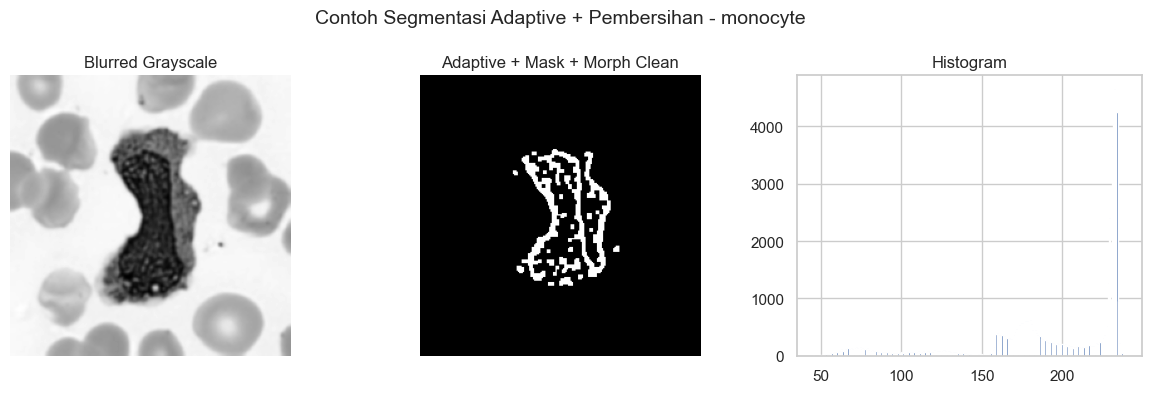

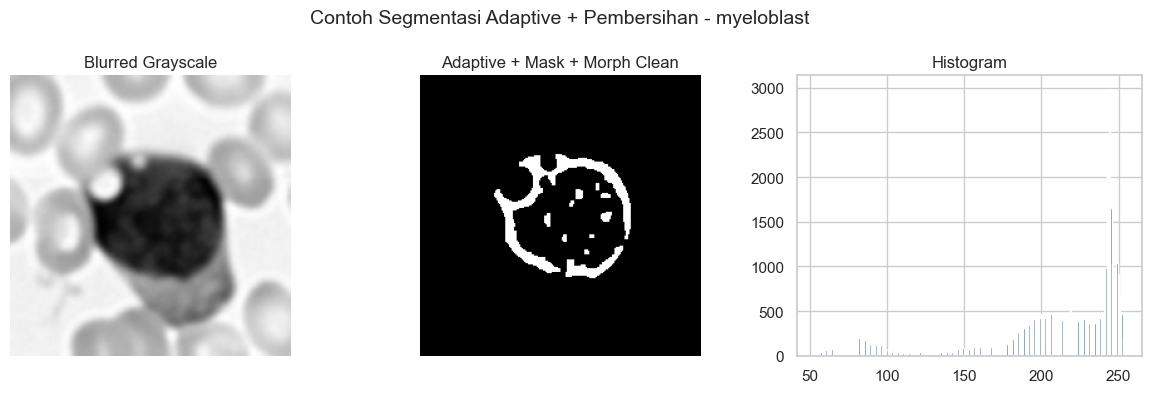

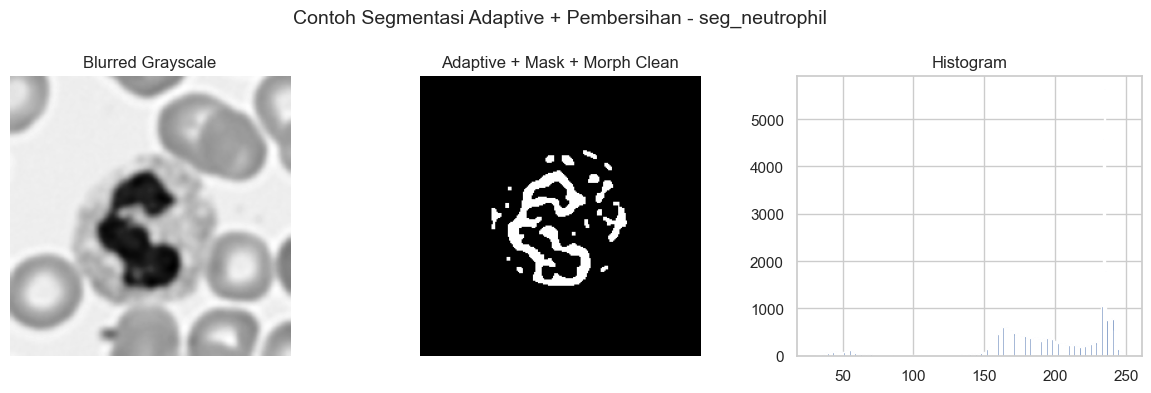

In [35]:
adaptive_segmented= []

kernel = np.ones((3, 3), np.uint8)

for img in preprocessed_images:
    adaptive = cv2.adaptiveThreshold(
        img,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=11,
        C=2
    )

    cleaned = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    adaptive_segmented.append(cleaned)


for category, (_, _, blurred) in example_images.items():
    
    adaptive = cv2.adaptiveThreshold(
        blurred,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=3
    )


    h, w = blurred.shape
    mask = np.zeros_like(blurred)
    cv2.circle(mask, (w//2, h//2), radius=min(w, h)//4, color=255, thickness=-1)

    masked_adaptive = cv2.bitwise_and(adaptive, adaptive, mask=mask)

    cleaned = cv2.morphologyEx(masked_adaptive, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Contoh Segmentasi Adaptive + Pembersihan - {category}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred Grayscale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cleaned, cmap='gray')
    plt.title("Adaptive + Mask + Morph Clean")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.hist(blurred.ravel(), bins=256)
    plt.title("Histogram")

    plt.tight_layout()
    plt.show()


watershed

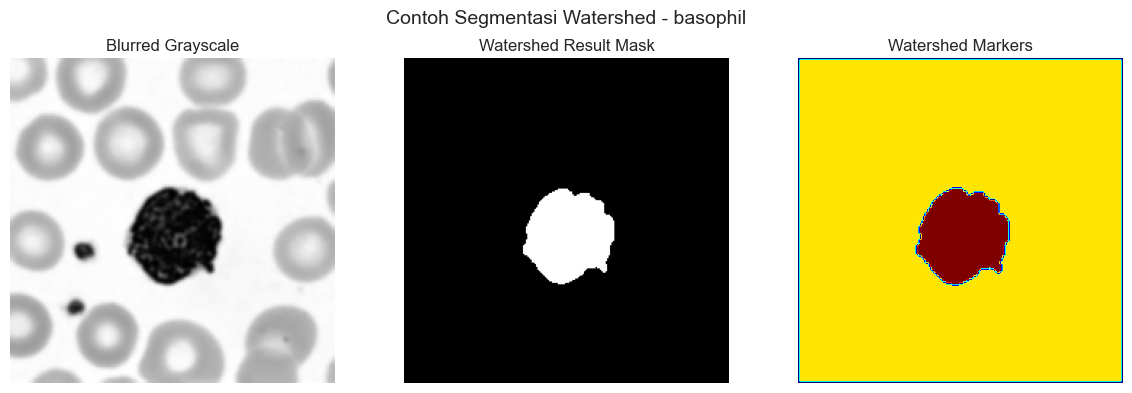

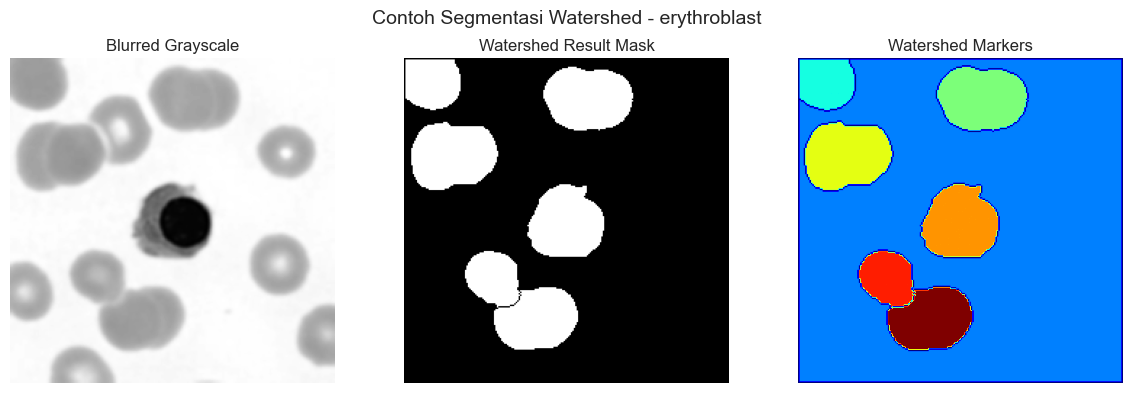

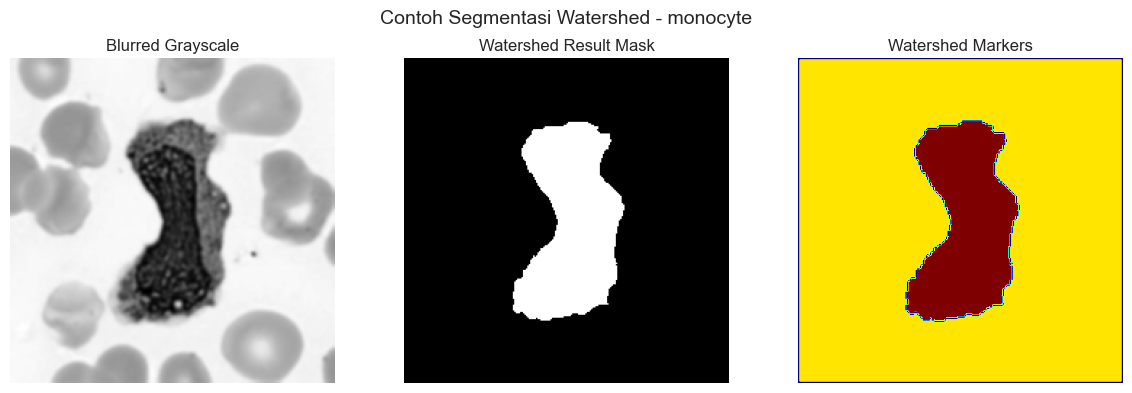

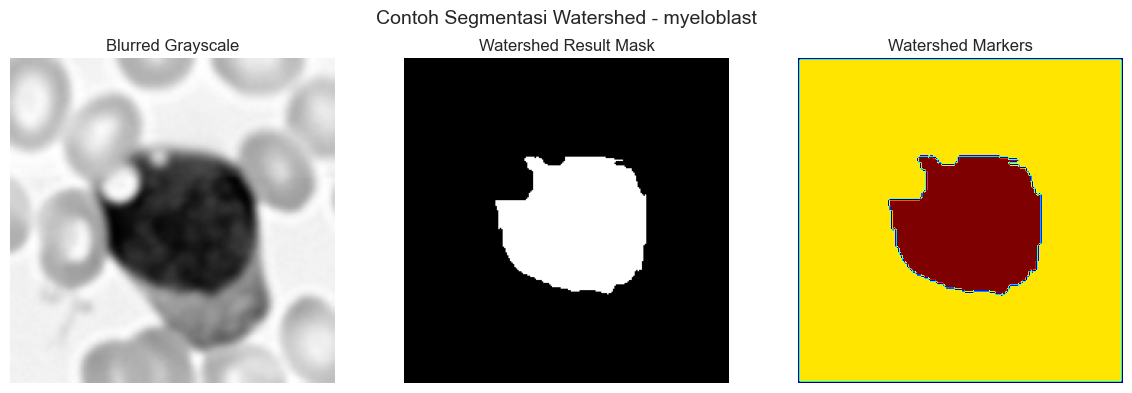

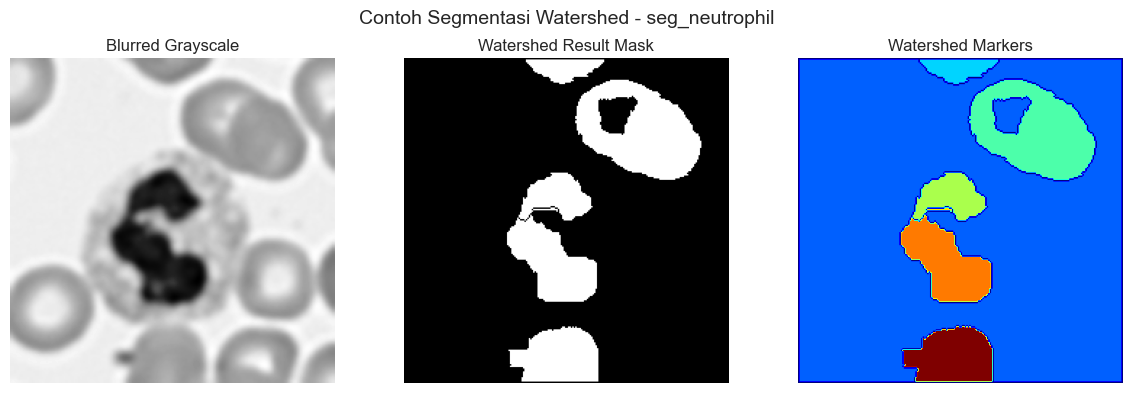

In [36]:
watershed_segmented = []

kernel = np.ones((3, 3), np.uint8)

for img in preprocessed_images:
    
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)


    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  
    markers[unknown == 255] = 0

    
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    
    mask = np.zeros_like(img)
    mask[markers > 1] = 255  

    watershed_segmented.append(mask)
for category, (_, _, blurred) in example_images.items():
    
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_color = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    # Hasil akhir
    result_mask = np.zeros_like(blurred)
    result_mask[markers > 1] = 255

    # Visualisasi
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Contoh Segmentasi Watershed - {category}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred Grayscale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(result_mask, cmap='gray')
    plt.title("Watershed Result Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(markers, cmap='jet')
    plt.title("Watershed Markers")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Ekstraksi fitur

In [37]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops

def extract_features(mask, gray_img):
    features_list = []

       
    binary_mask = mask > 0

    labeled_mask = label(binary_mask)

    for region in regionprops(labeled_mask):
        if region.area < 50:
            continue

        area = region.area
        perimeter = region.perimeter
        eccentricity = region.eccentricity

        minr, minc, maxr, maxc = region.bbox
        crop_mask = (labeled_mask[minr:maxr, minc:maxc] == region.label)
        crop_img = gray_img[minr:maxr, minc:maxc]

        masked_crop = np.where(crop_mask, crop_img, 0)

    
        quantized = (masked_crop / 4).astype(np.uint8)

        glcm = graycomatrix(quantized, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        features = {
            'area': area,
            'perimeter': perimeter,
            'eccentricity': eccentricity,
            'contrast': contrast,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation
        }
        features_list.append(features)

    return features_list


In [38]:
watershed_features = []
otsu_features = []
adaptive_features = []

for i, (mask, img) in enumerate(zip(watershed_segmented, preprocessed_images)):
    feats = extract_features(mask, img)
    watershed_features.append(feats)
    print(f"Watershed Image {i} features:")
    for j, f in enumerate(feats):
        print(f"  Object {j}: {f}")

for i, (mask, img) in enumerate(zip(otsu_segmented, preprocessed_images)):
    feats = extract_features(mask, img)
    otsu_features.append(feats)
    print(f"Otsu Image {i} features:")
    for j, f in enumerate(feats):
        print(f"  Object {j}: {f}")

for i, (mask, img) in enumerate(zip(adaptive_segmented, preprocessed_images)):
    feats = extract_features(mask, img)
    adaptive_features.append(feats)
    print(f"Adaptive Image {i} features:")
    for j, f in enumerate(feats):
        print(f"  Object {j}: {f}")


Watershed Image 0 features:
  Object 0: {'area': np.float64(3039.0), 'perimeter': np.float64(223.1370849898476), 'eccentricity': 0.3248384453789802, 'contrast': np.float64(20.153470185728256), 'homogeneity': np.float64(0.6334657913721772), 'energy': np.float64(0.27483179637574384), 'correlation': np.float64(0.8208402734030735)}
Watershed Image 1 features:
  Object 0: {'area': np.float64(1175.0), 'perimeter': np.float64(129.1126983722081), 'eccentricity': 0.44702375435400876, 'contrast': np.float64(55.352895752895755), 'homogeneity': np.float64(0.8176166266617241), 'energy': np.float64(0.40323559805780107), 'correlation': np.float64(0.8323803607793901)}
  Object 1: {'area': np.float64(2170.0), 'perimeter': np.float64(180.0243866176395), 'eccentricity': 0.7109467991409987, 'contrast': np.float64(71.1590909090909), 'homogeneity': np.float64(0.8425240588292972), 'energy': np.float64(0.3713652011485837), 'correlation': np.float64(0.8762421585562467)}
  Object 2: {'area': np.float64(2229.0),

In [39]:
import pandas as pd

def save_features_to_csv(features_list, method_name):
    flat_features = []
    for img_idx, feats in enumerate(features_list):
        for obj_idx, f in enumerate(feats):
            f = f.copy()  
            f['image'] = img_idx
            f['object'] = obj_idx
            flat_features.append(f)
    
    df = pd.DataFrame(flat_features)
    df.to_csv(f'{method_name}_features.csv', index=False)
    print(f'Saved {method_name}_features.csv with {len(df)} rows.')


save_features_to_csv(watershed_features, 'watershed')
save_features_to_csv(otsu_features, 'otsu')
save_features_to_csv(adaptive_features, 'adaptive')


Saved watershed_features.csv with 12 rows.
Saved otsu_features.csv with 12 rows.
Saved adaptive_features.csv with 88 rows.


In [40]:
import pandas as pd

def flatten_features(features_list, method_name):
    flat_features = []
    for img_idx, feats in enumerate(features_list):
        for obj_idx, f in enumerate(feats):
            f = f.copy()
            f['image'] = img_idx
            f['object'] = obj_idx
            f['method'] = method_name
            flat_features.append(f)
    return flat_features

combined_features = (
    flatten_features(watershed_features, 'Watershed') +
    flatten_features(otsu_features, 'Otsu') +
    flatten_features(adaptive_features, 'Adaptive')
)

df_all = pd.DataFrame(combined_features)
df_all.to_csv('all_segmented_features.csv', index=False)
print("Gabungan disimpan ke all_segmented_features.csv")


Gabungan disimpan ke all_segmented_features.csv


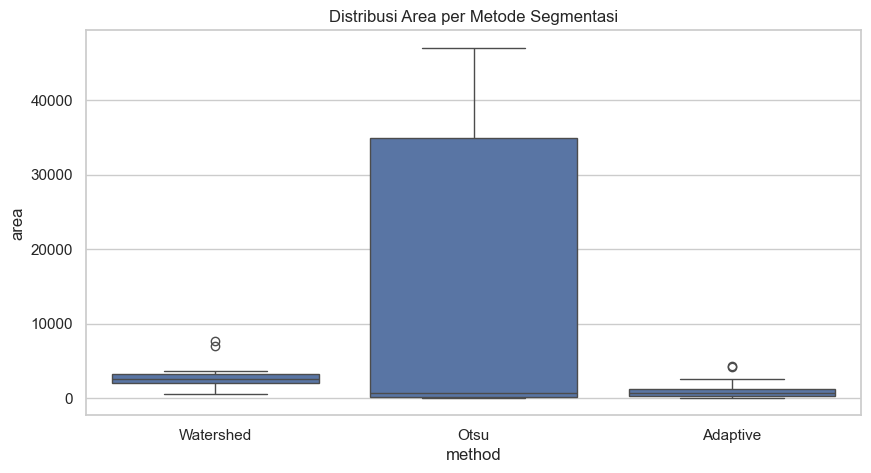

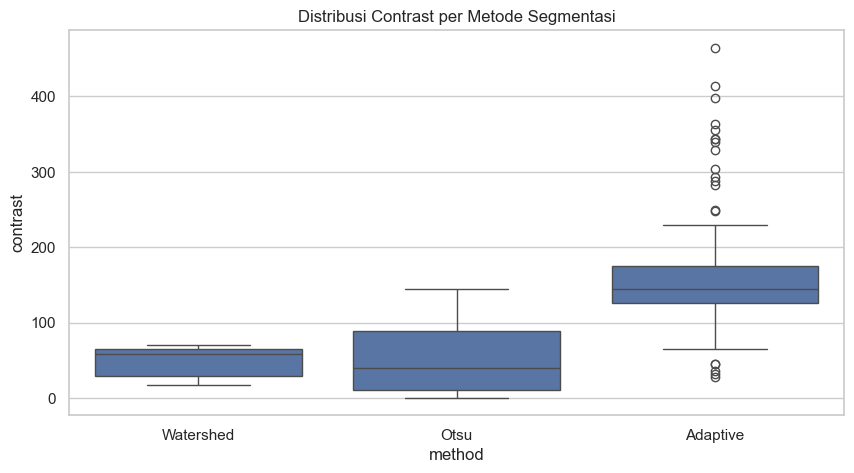

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
sns.boxplot(x="method", y="area", data=df_all)
plt.title("Distribusi Area per Metode Segmentasi")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x="method", y="contrast", data=df_all)
plt.title("Distribusi Contrast per Metode Segmentasi")
plt.show()


In [ ]:
import pandas as pd

df_all = pd.read_csv('all_segmented_features.csv')

count_per_method = df_all.groupby('method')['object'].count()
print("Jumlah objek per metode:\n", count_per_method)
mean_area = df_all.groupby('method')['area'].mean()
print("\nRata-rata area:\n", mean_area)

mean_ecc = df_all.groupby('method')['eccentricity'].mean()
print("\nRata-rata eccentricity:\n", mean_ecc)
mean_texture = df_all.groupby('method')[['contrast', 'homogeneity', 'energy', 'correlation']].mean()
print("\nRata-rata fitur tekstur:\n", mean_texture)


Jumlah objek per metode:
 method
Adaptive     88
Otsu         12
Watershed    12
Name: object, dtype: int64

Rata-rata area:
 method
Adaptive       826.568182
Otsu         16208.000000
Watershed     3136.083333
Name: area, dtype: float64

Rata-rata eccentricity:
 method
Adaptive     0.750817
Otsu         0.431845
Watershed    0.653811
Name: eccentricity, dtype: float64

Rata-rata fitur tekstur:
              contrast  homogeneity    energy  correlation
method                                                   
Adaptive   168.144216     0.772515  0.474175     0.791016
Otsu        53.092715     0.722636  0.273956     0.833075
Watershed   49.485874     0.779190  0.343284     0.877909


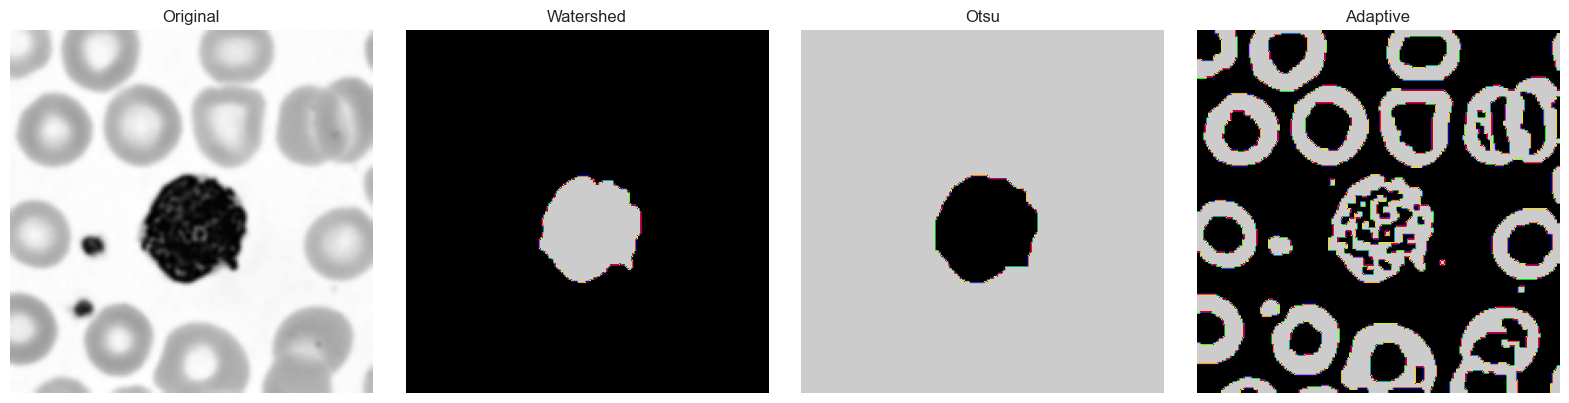

In [43]:
import matplotlib.pyplot as plt


idx = 0

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(preprocessed_images[idx], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(watershed_segmented[idx], cmap='nipy_spectral')
axes[1].set_title('Watershed')
axes[2].imshow(otsu_segmented[idx], cmap='nipy_spectral')
axes[2].set_title('Otsu')
axes[3].imshow(adaptive_segmented[idx], cmap='nipy_spectral')
axes[3].set_title('Adaptive')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


Confusion Matrix:
[[18  0  0]
 [ 0  3  0]
 [ 1  0  1]]

Classification Report:
              precision    recall  f1-score   support

    Adaptive       0.95      1.00      0.97        18
        Otsu       1.00      1.00      1.00         3
   Watershed       1.00      0.50      0.67         2

    accuracy                           0.96        23
   macro avg       0.98      0.83      0.88        23
weighted avg       0.96      0.96      0.95        23



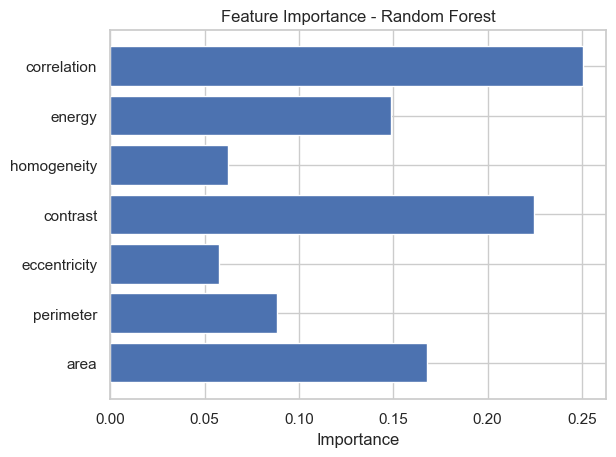

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

df_adaptive = pd.read_csv("adaptive_features.csv")
df_otsu = pd.read_csv("otsu_features.csv")
df_watershed = pd.read_csv("watershed_features.csv")

df_adaptive['method'] = 'Adaptive'
df_otsu['method'] = 'Otsu'
df_watershed['method'] = 'Watershed'

df_all = pd.concat([df_adaptive, df_otsu, df_watershed], ignore_index=True)
features = ['area', 'perimeter', 'eccentricity', 'contrast', 'homogeneity', 'energy', 'correlation']
X = df_all[features]
y = df_all['method']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt

importances = clf.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.show()


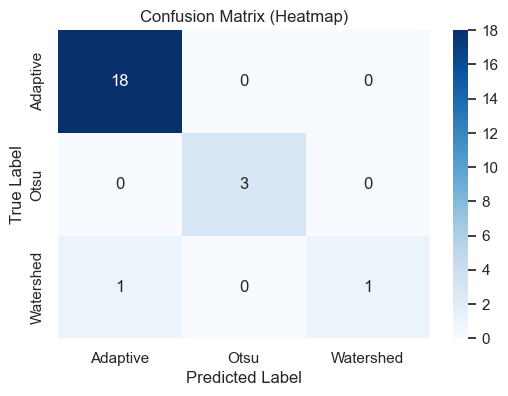

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Heatmap)")
plt.show()


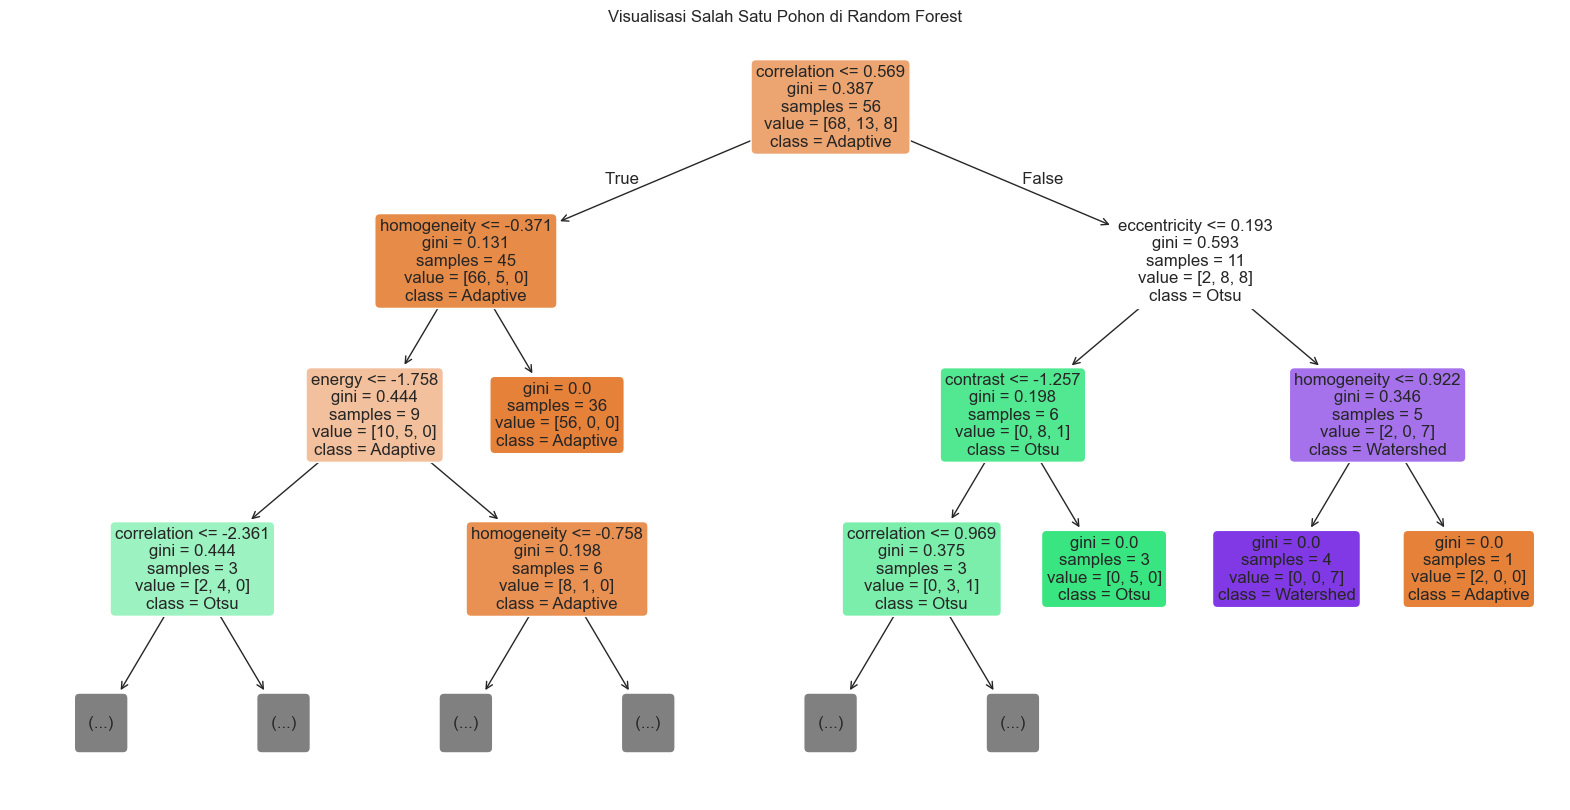

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(clf.estimators_[0], 
          feature_names=features, 
          class_names=clf.classes_, 
          filled=True, 
          rounded=True, 
          max_depth=3)
plt.title("Visualisasi Salah Satu Pohon di Random Forest")
plt.show()
